# MySurf


This application is used to display local surf conditions and predict future conditions for specific areas on the East Coast of the United States.

All data is queried from the National Oceanic and Atmosphereic Administration (NOAA). Current weather conditions come from bouys collecting data located along the coast and just offshore. Tide data is queryed from different stations along the coast. Weather forecast information is based upon latitude and longitude.

All data is collected and stored into a hash containing all relavent stations and all the information for each station.


By: Connor Secen

In [1]:
#all required imports for the full project to run properly
import requests
import datetime as dt
import pytz
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import io
import xml.etree.ElementTree as ET
import csv
import dis
import re
from IPython.display import display
import matplotlib.pyplot as plt
import folium

# Current Weather Conditions along the East Coast

This section is used to collect real time data on current weather data points such as
wind speed & direction, water temperature, and air temperature from multiple bouy locations
off of the East Coast of the United States.

The queryData function is used to collect the 3 most recent data entries that are being produced. These
top 3 values for each type of condition will then be averaged to have a resonable depiction of what the
current conditions are in the given locations.

All of the data is stored into a pandas dataframe allowing it to be represented in a visually appealling manor.
This also allows for easy access of the information for further use.

In [2]:
#format the URL with the proper station ID and query for the data
def queryData(station):
    
    #format the URL
    url = 'http://www.ndbc.noaa.gov/station_page.php?station=' + station
    
    #query for the data from the specific station
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    table = soup.find('table', attrs={'class':'dataTable'})

    #create a dataframe from the table scraped from the site
    df = pd.read_html(str(table), flavor='html5lib')[0]
    
    #clean the dataframe so that it only contains the column descriptors and the 3 most recent data entries,
    #remove the unnecessary columns and renumber the column headers
    df = df[1:5]
    df = df.drop([7,8,9,11,14,15,16,17], axis=1)
    df.columns = [1,2,3,4,5,6,7,8,9,10]
    
    #grad the lat. and long. of each station from the site as well and return it as a list
    tags = soup.find_all('b')
    
    #data feed is inconsistent, so make sure that we are grabbing the correct line, containing the
    #lat. and long. for that station
    for t in tags:
        points = str(t)
        point = points.replace('<b>', '')
        n = 4
        q=re.match(r'^((?:[^\s]*\s){%d}[^\s]*)\s(.*)' % (n-1), point)
        if q: 
            a = q.groups()
            if a[0][0].isdigit():
                point = a[0]
                str1 = point.split(' ')
                #check if the lat. needs to be negative
                if str1[1] == 'S':
                    lat = float(str1[0]) * -1
                else:    
                    lat = float(str1[0])
                #check if the long needs to be negative
                if str1[3] == 'W':
                    long = float(str1[2]) * -1
                else:
                    long = float(str1[2])
                point = [str(lat), str(long)]
                break
        else:
            point = ['N/A', 'N/A']
        
    #return the new, smaller dataframe and the lat. and long.
    return [df, point]

In [3]:
#used to find if any of the values in the dataframe are null and if they are, do not take them 
#into account when finding the average
def findNull(df, col):
    
    #create all necessary local variables for incrementing and counting
    avg = 0.0
    i = 2
    c = 0.00
    
    #loop through the dataframe collecting all the data
    while i < 5:
        if df[col][i] != '-':
            num = float(df[col][i])
            numStr = ("%.2f" % round(num,2))
            avg += float(numStr)
            c += 1.0
        i += 1
    
    #check if all entries were missing and if they are return N/A, otherwise return avg
    if avg == 0.0:
        return 'N/A'
    else:
        avgStr = ("%.2f" % round(avg,2))
        newAvg = float(avgStr)/c
        retAvg = ("%.2f" % round(newAvg,2))
        return float(retAvg)

In [4]:
#used to find the date of the entry and average all the information from the dataframe
def avgData(info, loc):
    
    #info is a list, get the data from the list here
    df = info[0]
    points = info[1]
    
    #create degrees fahrenheit symbol
    degree = '\N{DEGREE SIGN}F'
    
    #get the date from the dataframe
    date = df[1][2] + '-' + df[2][2] + ' ' +  df[3][2]
    date = date.replace("\xa0", " ")
        
    #find the current wind direction
    if df[4][2] == '-':
        currWindDir = 'N/A'
    else:
        currWindDir = df[4][2]
        
    #average the wind speed, wind direction, air temp, and water temp
    avgWindSpd = findNull(df, 5)
    avgWvHt = findNull(df, 7)
    avgAirTemp = findNull(df, 9)
    avgWtrTemp = findNull(df, 10)
    
    wndSpdLabel = 'Avg. Wind Speed kts'
    wvHtLabel = 'Avg. Wave Height ft'
    airTempLabel = 'Avg. Air Temp. ' + degree
    wtrTempLabel = 'Avg. Water Temp.' + degree

    #create a new dataframe to be returned with all the new averaged data and labels
    data = pd.DataFrame({'Date':date, 'Current Wind Direction':currWindDir, wndSpdLabel:avgWindSpd, wvHtLabel:avgWvHt, 
                         airTempLabel:avgAirTemp, wtrTempLabel:avgWtrTemp, 'Latitude':points[0], 'Longitude':points[1]}, 
                         index=[loc])
    
    #reorder the labels so they display properly
    data = data[['Date', 'Current Wind Direction', wndSpdLabel, wvHtLabel, airTempLabel, wtrTempLabel,'Latitude', 
                 'Longitude']]
    
    return data

In [5]:
#used to call all other functions and store all returned data into a hash, where the key is the location name
#and the value is a list of different data stores such as arrays and pandas dataframes
def gatherData(stations, mainCurrDF):
    #loop through all the stations, querying for the data and adding the data to the second index
    #of the list in the value
    for k,v in stations.items():
        df = queryData(v[0])
        v.append(df[0])
        v.append(df[1])
        df2 = avgData(df,k)
        v.append(df2)
        mainCurrDF = mainCurrDF.append(df2)
        
    return mainCurrDF

In [6]:
#create a dictionary of list, where the key is the name of the Beach or coastal area, and the value is a list
#that contains the station ID in the first index
stations = {'Ocean City, MD':['OCIM2','8570283'], 'Lewes, DE':['LWSD1','8557380'], 
            'Atlantic City, NJ':['ACYN4','8534720'], 'Virginia Beach, VA':['CHYV2','8639168'], 
            'Duck, NC':['DUKN7','8651370'], 'Oregan Inlet, NC':['ORIN7','8652659'], 
            'Cape Hatteras, NC':['HCGN7','8654400'], 'Cape Lookout, NC':['CLKN7','8656841'], 
            'Wilmington, NC':['JMPN7','8658559'], 'Myrtle Beach, SC':['MROS1','8661070'], 
            'Sebastians Inlet, FL':['SIPF1','8722004'], 'Nantucket Island, MA':['NTKM3','8449130']}

#create an empty dataframe to be appended too containing current data on all locations
mainCurrDF = pd.DataFrame()

#get the dataframe containing all locations and display
totalDF = gatherData(stations, mainCurrDF)
display(totalDF)

,Date,Current Wind Direction,Avg. Wind Speed kts,Avg. Wave Height ft,Avg. Air Temp. °F,Avg. Water Temp.°F,Latitude,Longitude
"Ocean City, MD",05-29 3:24 pm,ESE,4.43,N/A,68.2,69.93,38.328,-75.091
"Lewes, DE",05-29 3:24 pm,SSE,5.1,N/A,70.33,66.6,38.783,-75.119
"Atlantic City, NJ",05-29 3:24 pm,N/A,N/A,N/A,65.9,59.07,39.357,-74.418
"Virginia Beach, VA",05-29 3:24 pm,E,5.4,N/A,71.73,N/A,36.926,-76.007
"Duck, NC",05-29 3:24 pm,SE,9.23,N/A,70.63,64.87,36.184,-75.746
"Oregan Inlet, NC",05-29 3:24 pm,NW,2.57,N/A,74.23,73.53,35.796,-75.548
"Cape Hatteras, NC",05-29 3:24 pm,WNW,4.37,N/A,75.57,75.53,35.209,-75.704
"Cape Lookout, NC",05-29 2:00 pm,SSW,11.67,N/A,N/A,N/A,34.622,-76.525
"Wilmington, NC",05-29 3:24 pm,SSW,11.3,N/A,76.63,76.5,34.213,-77.786
"Myrtle Beach, SC",05-29 3:24 pm,N/A,N/A,N/A,N/A,N/A,33.656,-78.916


# Forecasted Tides

This sections gathers data for the predicted tides for all regions that data was gathered in the previous section.

The information comes from the stations located along the coast. The information comes in the form of a csv file and is converted into a graph allowing for a nice visual representation of the data, making it easier to understand.

In [7]:
#format the url for the proper search query of the data
def makeURL(station):
    
    #get the current date
    tz = pytz.timezone('US/Eastern')
    date = dt.datetime.now(tz).strftime('%Y%m%d')
    #get the date 1 day in the future
    date2 = dt.datetime.now(tz) + dt.timedelta(days=1)
    date2 = date2.strftime('%Y%m%d')
    
    #build the url adding the additional new parmeters to the string
    firstpath = 'https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL'
    secondpath = '&begin_date=' + date
    thirdpath = '&end_date=' + date2 + '&datum=MLLW'
    fourthpath = '&station=' + station
    fifthpath = '&time_zone=lst_ldt&units=english&interval=hilo&format=csv'
    
    #concatinate all the strings to form single URL
    url = firstpath+secondpath+thirdpath+fourthpath+fifthpath
    return url

In [8]:
def findCurrLine(tideDates):
    #get a list of the dates for listed in the current data pull
    x = tideDates['Date Time'].tolist()
    
    #get the current time on the east coast of the United States
    tz = pytz.timezone('US/Eastern')
    ect = dt.datetime.now(tz).strftime('%d %H.%M')
    
    #ugly way to do this, but at the moment, cannot think of another way to do this
    #get the day and the current time of for comparison
    day = ect.split(' ')
    curr = [int(day[0]), float(day[1])]
    
    #create list to hold the times
    intTime = []
    
    #loop through all the dates and times listed in the data and format them properly
    for t in x:
        t = t.replace(':', '.')         #get rid of the colin
        t = t.split(' ')                #split the string in two
        d = t[0].split('-')             #split the date into year, month, and day    
        intTime.append([int(d[2]), float(t[1])])
        
    #create needed local variables
    idx = 0
    i = 0   
    
    #find the index that it falls between
    while i < 7:
        if curr[0] == intTime[i][0]:
            if intTime[i+1][0] > curr[0] or curr[1] < intTime[i+1][1]:
                idx = i
                break
        i += 1
        
    #find the difference in the time between the 2 indecies
    
    #get the start time and the end time of the interval
    start = intTime[idx][1]
    end = intTime[idx + 1][1]
    
    #convert the numbers to strings, still not the best way to do this
    startStr = str(start)
    endStr = str(end)
    
    #split the time into hours and minutes
    start = startStr.split('.')
    end = endStr.split('.')
    
    #check if the minutes needs to be mulitplied by 10
    #start interval
    if len(start[1]) == 1:
        start1 = int(start[1]) * 10
    else:
        start1 = int(start[1])
    #end interval
    if len(end[1]) == 1:
        end1 = int(end[1]) * 10
    else:
        end1 = int(end[1])
        
    #get the hour difference
    h = abs(int(start[0]) - int(end[0]))
    #get the minute difference
    m = abs(start1 - end1)

    #get the total number of minutes in the interval
    totalMin = (h*60) + m
    
    #format the current time so that it is split into hours and minutes
    currStr = str(curr[1])
    currStr = currStr.split('.')
    
    #check if minutes needs to be multiplied by 10
    if len(currStr[1]) == 1:
        curr1 = int(currStr[1]) * 10
    else:
        curr1 = int(currStr[1])
        
    #get difference between start time and current time
    h2 = abs(int(currStr[0]) - int(start[0]))
    m2 = abs(curr1 - start1)
    
    totalMin2 = (h2*60) + m2
    
    #find the ratio between the total difference and the current difference
    diff = totalMin2/totalMin 
    
    #find the x-value where the line of the current time needs to go
    currTimeLine = idx + diff
    return currTimeLine

In [9]:
def makeGraph(tide):
    #create the graph
    graph = tide.plot(figsize=(20,10))
    
    #get the indecies
    x = tide['Date Time'].tolist()
    xi = [0,1,2,3,4,5,6]
    time = tide.iloc[:,1].tolist()

    #get the x-value for the current time line
    currTimeLine = findCurrLine(tide)
    labels = "Current time"
    
    #style the graph so it looks good
    plt.xticks(xi,x)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='black')
    plt.axvline(x=currTimeLine, color='green', label='Current time')
    plt.rcParams.update({'font.size': 15})
    
    plt.xlabel('Date and Time',fontsize=22, color='blue')
    plt.ylabel('Height',fontsize=22, color='blue')
    plt.legend()
    
    return graph

In [10]:
def createMap(df):
    
    #get the lat and long and convert to floats
    lat = df['Latitude']
    long = df['Longitude']
    lat = float(lat)
    long = float(long)
    
    #create the map
    location = folium.Map(location=[lat, long], zoom_start=12)
    folium.Marker(location=[lat, long]).add_to(location)
    
    return location

In [11]:
def displayData(name):
    
    #get the id
    id = stations[name][1]
    url = makeURL(id)
    tides = pd.read_csv(url)
    graph = makeGraph(tides)
    thisDF = stations[name][4]
    loc = createMap(thisDF)
    display(thisDF)
    display(loc)

# Display all the current information and the tides for a specific location

,Date,Current Wind Direction,Avg. Wind Speed kts,Avg. Wave Height ft,Avg. Air Temp. °F,Avg. Water Temp.°F,Latitude,Longitude
"Duck, NC",05-29 3:24 pm,SE,9.23,N/A,70.63,64.87,36.184,-75.746


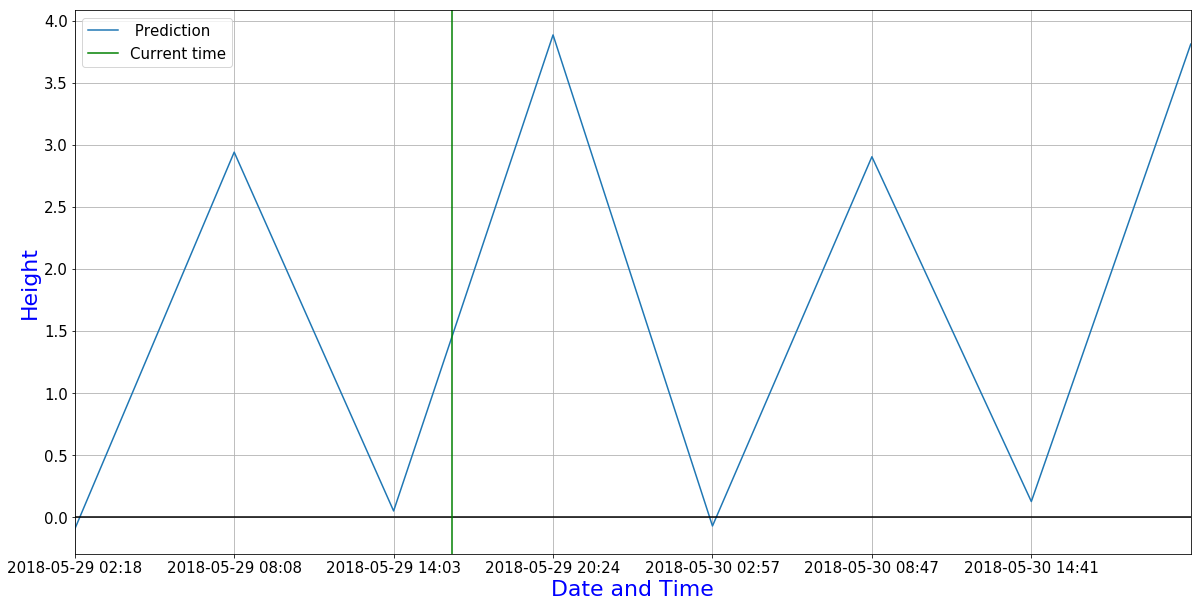

In [20]:
#Input the name of the location you would wish to find information on, based on the list above
displayData('Duck, NC')

# Forecasted Weather Data

This section gathers forecasted data for wind speed & direction, wave height, max, min, & apparent temperature, and relative humidity. This data is collected for each station based on latitude and longitude and stored into a hash of
hashes. The data is then examined and predictions of the surf conditions are made for each location.

All information comes in the form of a single XML document for each station. The document is parsed and stored into a hash that is easier to access for future use.

In [13]:
#used to format the URL that is used to query data for the forecasted weather data. The function
#adds the current date and the date 7 days in the future and adds all the tags required to query
#all the necessary data points
def formatURL(lat, lon):
    
    #set the time zone for the the areas the data is coming from
    tz = pytz.timezone('US/Eastern')
    #get the current date and the date 7 days in the future
    date = dt.datetime.now(tz).strftime('%Y-%m-%d')
    date2 = dt.datetime.now(tz) + dt.timedelta(days=7)
    date2 = date2.strftime('%Y-%m-%d')
    
    firstpath = 'https://graphical.weather.gov/xml/sample_products/browser_interface/ndfdXMLclient.php?lat=' + lat
    secondpath = '&lon=' + lon
    thirdpath = '&product=time-series&begin=' + date + 'T00:00:00'
    fourthpath = '&end=' + date2 + 'T00:00:00'
    fifthpath = '&wspd=wspd&wdir=wdir&waveh=waveh&maxt=maxt&mint=mint&appt=appt&pop12=pop12&rh=rh'
    
    #concatinate all the strings to form single URL
    url = firstpath+secondpath+thirdpath+fourthpath+fifthpath
    return url

In [14]:
#used to parse the forecast information that comes in the form of an xml file. The function loops
#through the tags in the file and finds all the information that is to be gathered
def parseXML(url):
    # creating HTTP response object from given url
    r = requests.get(url)
 
    # saving the xml file
    with open('data.xml', 'wb') as f:
        f.write(r.content)
        
    #import pdb; pdb.set_trace()
    
    #create a tree from the xml document
    tree = ET.parse('data.xml')
    root = tree.getroot()
    
    #skip to the second tag in the tree
    root1 = root[1]
    
    #create all the data structures needed to store all the data from the 
    #xml tree structure
    #hash of the types of time layouts and the times included
    time = {}
    #hash of the data values
    data = {}
    #name of the element
    name = ''
    #contains the hash of all the values and the time layout
    fullData = []
    
    
    #parse the xml file, checking for specific tags
    for child in root1:
        #check for the time layouts and the actual times
        if child.tag == 'time-layout':
            values = []
            for child2 in child:
                if child2.tag == 'layout-key':
                    key = child2.text
                else:
                    values.append(child2.text)
            time[key] = values
        #check for all the data that what queried
        elif child.tag == 'parameters':
            for child2 in child:
                #check which time layout this data point used
                timeType = child2.attrib['time-layout']
                temp = []
                for child3 in child2:
                    if child3.tag == 'waves':
                        for ele in child3:
                            if ele.tag == 'name':
                                name = ele.text
                            else:
                                temp.append(ele.text)
                    else:
                        if child3.tag == 'name':
                            name = child3.text
                        else:
                            temp.append(child3.text)
                #finish adding all the data to the data structures
                data[name] = [timeType, temp]
            #fullData = [data]
                
            
                
    #return all the data in the form of a list, with the time layout hash in the 
    #first position and the hash containing all the data collected
    return [time, data]#fullData]        

In [15]:
def formatUTCTime(str1):
    
    #list to hold the number of days in each month
    dayCount = [31,28,31,30,31,30,31,31,30,31,30,31]
    
    #split the entire string into the date and the time
    str2 = str1.split('T')
    date = str2[0]
    time = str2[1]
    
    #split the time into hours, minutes, seconds
    timeSplit = time.split(':')
    
    #create need variables
    newYearBool = False
    finalDate = ''

    #preset the date if nothing needs to be changed
    newDate = date.split('-')
    newYear = newDate[0]
    newMonth = newDate[1]
    newDay = newDate[2]

    #Check if the time is behind GMT and account for the difference
    if (time[8] == '-'):   
    
        #split the date up into year, month, day
        timeSplit2 = timeSplit[2].split('-')
    
        #grab the time different and the actual time
        num = int(time[9:11])   #difference
        num1 = int(time[0:2])   #time
         
        #find the difference
        newNum = num1 - num
    
        #check if the time went back a day into the negatives and needs to be
        #adjusted accordingly
        if (newNum < 0):
            newNum = newNum + 24
        
        #check if the date needs to be adjusted because of the change in time
        if (newNum > num1):

            #get the current day that is in the string and move it back a day
            day = int(newDate[2])
            newDay = day - 1
        
            #check if the day is now 0 or in a new month
            if (newDay == 0):
                #get the month that is in the string
                month = int(newDate[1])
                        
                #check if it is the first month of the year
                if (month == 1):
                    #adjust for the month moving back to the new year
                    newMonth = month + 11
                    #change the new day according to the change of month
                    newDay = newDay + dayCount[month - 1]
                    #indicate if the year needs to be changed
                    newYearBool = True
                #if it is not the first month, adjust the month accordingly
                else:
                    #move the month back by one and grab the index of the days in the count list
                    newMonth = month - 1
                    idx = month - 2
                    
                    #adjust the days
                    newDay = newDay + dayCount[idx]
                
                #change the year by decreasing it by one if it needs to be
                if (newYearBool):
                    year = int(newDate[0])
                    newYear = year - 1  
        
    #check if the difference in the time is positive
    elif (time[8] == '+'):
        
        #get the actual time in GMT and get the difference
        timeSplit2 = timeSplit[2].split('+')
    
        num = int(time[9:11])
        num1 = int(time[0:2])
    
        #calculate the difference
        newNum = num1 + num
    
        #check if the time goes into the next day
        if (newNum > 24):
            newNum = newNum - 24
        
        #check if the day needs to be adjusted
        if (newNum < num1):
            
            #get the current date and add one day to it
            day = int(newDate[2])
            newDay = day + 1
        
            #get the current month
            month = int(newDate[1])

            #check if the new date is greater than the amount of days in the month
            if (newDay > dayCount[month - 1]):
                #get the new adjusted day
                newDay = newDay - dayCount[month - 1]
                
                #move the month up by one
                newMonth = month + 1
                
                #if the month is greater than the number of month, subtract 12
                if (newMonth > 12):
                    newMonth = newMonth - 12
                
                #check if the year needs to be adjusted and add 1
                if (newMonth < month):
                    year = int(newDate[0])
                    newYear = year + 1
            
    #check if the hour needs to have a zero added to the begining
    if (newNum < 10):
        newNum = '0' + str(newNum)

    #build the string of the date into the proper format
    finalDate = str(newYear) + '-' + str(newMonth) + '-' + str(newDay) # + ' ' + str(newNum) + ':' + timeSplit[1] + ':' + timeSplit2[0]
    return(finalDate)
    

In [16]:
def appendStartandEnd(lst):
    
    newList = []
    i = 0
    while (i < len(lst)):
        newList.append(lst[i] + ' - ' + lst[i+1])
        i += 2
        
    return newList

In [17]:
def buildData(dates, data):
    
    i = 0
    newData = {}
    while (i < len(dates)):
        newData[dates[i]] = data[i]
        i += 1
        
    return newData

In [18]:
def tempForecast(data, times):
    
    #This section is used to create a dataframe of the forecasted max temperature for the next 10 days
    #get the list of max temps
    maxData = data['Daily Maximum Temperature'][1]
    #get the list of times that corresponds to max 
    maxTime = times[data['Daily Maximum Temperature'][0]]
    #get the list of min temps
    minData = data['Daily Minimum Temperature'][1]
    #get the list of times that corresponds to min
    minTime = times[data['Daily Minimum Temperature'][0]]
    
    rainData = data['12 Hourly Probability of Precipitation'][1]
    rainTime = times[data['12 Hourly Probability of Precipitation'][0]]
    
    newMaxTime = []    
    for time in maxTime:
        newMaxTime.append(formatUTCTime(time))
    
    newMinTime = []    
    for time in minTime:
        newMinTime.append(formatUTCTime(time))
        
    newRainTime = []    
    for time in minTime:
        newRainTime.append(formatUTCTime(time))
     
    newMaxTime = appendStartandEnd(newMaxTime)
    newMinTime = appendStartandEnd(newMinTime)
    newRainTime = appendStartandEnd(newRainTime)
        
    newMaxData = buildData(newMaxTime, maxData)
    newMinData = buildData(newMinTime, minData)
    newRainData = buildData(newRainTime, rainData)
    
    maxDF = pd.DataFrame(newMaxData, index = ['Daily Maximum Temperature'])
    minDF = pd.DataFrame(newMinData, index = ['Daily Minimun Temperature'])
    rainDF = pd.DataFrame(newMaxData, index = ['12 Hourly Probability of Precipitation'])
    
    display(maxDF)
    display(minDF)
    display(rainDF)

In [19]:
forecastData = {}

for idx, row in totalDF.iterrows():
    lat = row['Latitude']
    long = row['Longitude'] 
    
    url = formatURL(lat, long)
    data = parseXML(url)
    
    forecast = data[1]
    #get the hash containing the time ranges for all the data
    times = data[0]
    forecastData[idx] = forecast

tempForecast(forecastData['Duck, NC'], times)   

,2018-05-29 - 2018-05-29,2018-05-30 - 2018-05-30,2018-05-31 - 2018-05-31,2018-06-01 - 2018-06-01,2018-06-02 - 2018-06-02,2018-06-03 - 2018-06-03,2018-06-04 - 2018-06-04
Daily Maximum Temperature,80,79,83,86,84,79,77


,2018-05-29 - 2018-05-30,2018-05-30 - 2018-05-31,2018-05-31 - 2018-06-01,2018-06-01 - 2018-06-02,2018-06-02 - 2018-06-03,2018-06-03 - 2018-06-04
Daily Minimun Temperature,71,71,73,73,71,68


,2018-05-29 - 2018-05-29,2018-05-30 - 2018-05-30,2018-05-31 - 2018-05-31,2018-06-01 - 2018-06-01,2018-06-02 - 2018-06-02,2018-06-03 - 2018-06-03,2018-06-04 - 2018-06-04
12 Hourly Probability of Precipitation,80,79,83,86,84,79,77


In [17]:
#used to avgerage the wind direction. The directions are taken in as string representations of the
#direction, coverted to a numerical representation, and then converted back into string representations
'''
def avgWD(df):
    
    #dictionary holding ranges of values for wind direction
    #key = numerical representation
    #value = string representation
    numDir = {[348.76,11.25]:'N', [11.26,33.75]:'NNE', [33.76,56.25]:'NE', [56.26,78.75]:'ENE', [78.76,101.25]:'E',
                [101.26,123.75]:'ESE', [123.76,146.25]:'SE', [146.26,168.75]:'SSE', [168.76,191.25]:'S',
                [191.26,213.75]:'SSW', [213.76,236.25]:'SW', [236.26,258.75]:'WSW', [258.76,281.25]:'W',
                [281.26,303.75]:'WNW', [303.76,326.25]:'NW', [326.26,348.75]:'NNW'}
    
    #dictionary holding value for wind direction
    #key = string representation
    #value = numerical representation
    strDir = {'N':360, 'NNE':22.5, 'NE':45, 'ENE':67.5, 'E':90, 'ESE':112.5, 'SE':135, 'SSE':157.5, 'S':180,
             'SSW':202.5, 'SW':225, 'WSW':247.5, 'W':270, 'WNW':292.5, 'NW':315, 'NNW':337.5}
    
    #variables to hold the average, index and count, repectively
    avg = 0.0
    i = 2
    c = 0.0
     
    #loop through column checking for missing entries
    while i < 5:
        if df[4][i] == '-':
            c += 1.0
        i += 1
        
    if c == 3.0:
        return 'N/A'
    else:
        dir1 = strDir[df[4][2]]
        dir2 = strDir[df[4][3]]
        dir3 = strDir[df[4][4]]
'''     